# Model Building

Build a model that predicts if Punxsatawney Phil would see his shadow or not.

## Prepare the Data

In [1]:
import pandas as pd

### Load Data

Load the data and filter out the columns we don't need.

In [2]:
df = pd.read_csv('data/imputed/state-predictions.csv', encoding='utf-8')
df = df.filter(items=['shadow', 'latitude', 'longitude', 
                      'feb_state_temp', 'feb_region_temp',
                      'mar_state_temp', 'mar_region_temp'])
df

,shadow,latitude,longitude,feb_state_temp,feb_region_temp,mar_state_temp,mar_region_temp
0,Full Shadow,41.6219,-72.7273,18.7,15.6,31.5,27.6
1,Full Shadow,38.9896,-75.5050,24.2,15.6,39.5,27.6
2,Full Shadow,45.3695,-69.2428,11.8,15.6,21.3,27.6
3,Full Shadow,39.0550,-76.7909,23.6,15.6,39.3,27.6
4,Full Shadow,42.2596,-71.8083,18.5,15.6,30.8,27.6
...,...,...,...,...,...,...,...
2767,Full Shadow,44.6243,-89.9941,13.5,12.6,25.7,26.3
2768,Full Shadow,42.0751,-93.4960,24.8,19.7,40.3,34.5
2769,Full Shadow,44.3467,-85.4102,23.6,19.7,35.0,34.5
2770,No Shadow,46.2807,-94.3053,14.0,19.7,30.4,34.5


### Encode the Target

Convert from the strings of "Full Shadow" and "No Shadow" to integers of 1 and 0 respectively.

In [3]:
df.shadow = df.shadow.transform(lambda shadow: 1 if shadow == 'Full Shadow' else 0).astype(int)

### Understand Our Data

Let's take a look at our data.

In [4]:
df.shadow.value_counts()

1    2346
0     426
Name: shadow, dtype: int64

In [5]:
df.shadow.value_counts(normalize=True)

1    0.84632
0    0.15368
Name: shadow, dtype: float64

array([[<AxesSubplot:title={'center':'shadow'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'feb_state_temp'}>,
        <AxesSubplot:title={'center':'feb_region_temp'}>,
        <AxesSubplot:title={'center':'mar_state_temp'}>],
       [<AxesSubplot:title={'center':'mar_region_temp'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

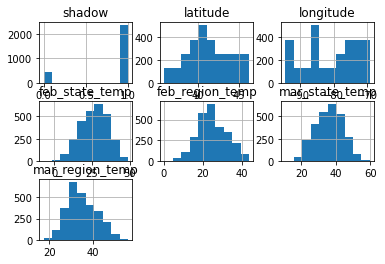

In [6]:
df.hist()

shadow
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

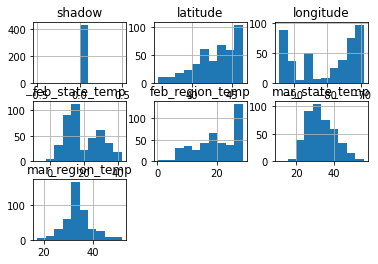

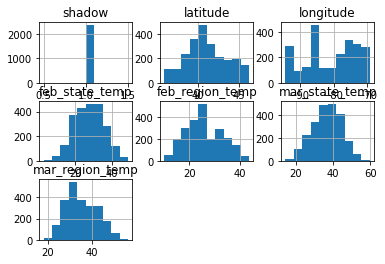

In [7]:
df.groupby('shadow').hist()

### Targets & Features

Get the values for the target and the features.

In [8]:
df_target = df.iloc[:, 0]
df_features = df.iloc[:, 1:].astype(float)

X, y = df_features.values, df_target.values

In [9]:
X.shape, y.shape

((2772, 6), (2772,))

### Balancing Our Data

Our data is way out of balance. Balance it to improve the results of our model.

In [10]:
from imblearn.over_sampling import RandomOverSampler

In [11]:
oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversampler.fit_resample(X, y)

In [12]:
X_over.shape, y_over.shape

((4692, 6), (4692,))

## Build Some Models

In [13]:
import pickle

models = []

### Train/Test Split

Split the training and testing data 80/20.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=0.80, test_size=0.20, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3753, 6), (939, 6), (3753,), (939,))

### Train a Support Vector Machine

In [17]:
from sklearn.svm import LinearSVC

In [18]:
svm = LinearSVC(dual=False, random_state=0).fit(X_train, y_train)

In [19]:
score = svm.score(X_test, y_test)
models.append((score, 'Support Vector Machine', svm))
score

0.650692225772098

In [20]:
with open('model/woodchuckin-svm.pickle', 'wb') as file:
  pickle.dump(svm, file)

### Train a Logistic Regresion

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=0).fit(X_train, y_train)

In [23]:
score = lr.score(X_test, y_test)
models.append((score, 'Logistic Regression', lr))
score

0.6538871139510117

In [24]:
with open('model/woodchuckin-lr.pickle', 'wb') as file:
  pickle.dump(lr, file)

### Train a Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0).fit(X_train, y_train)

In [27]:
score = rf.score(X_test, y_test)
models.append((score, 'Random Forest', rf))
score

0.9616613418530351

In [28]:
with open('model/woodchuckin-rf.pickle', 'wb') as file:
  pickle.dump(rf, file)

### Train a KNN Classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

In [31]:
score = knn.score(X_test, y_test)
models.append((score, 'K-Nearest Neighbors', knn))
score

0.9361022364217252

In [32]:
with open('model/woodchuckin-knn.pickle', 'wb') as file:
  pickle.dump(knn, file)

### Select a Model

Select the model with the highest score.

In [33]:
models.sort(reverse=True)
models

[(0.9616613418530351,
  'Random Forest',
  RandomForestClassifier(max_depth=5, random_state=0)),
 (0.9361022364217252,
  'K-Nearest Neighbors',
  KNeighborsClassifier(n_neighbors=3)),
 (0.6538871139510117,
  'Logistic Regression',
  LogisticRegression(multi_class='ovr', random_state=0)),
 (0.650692225772098,
  'Support Vector Machine',
  LinearSVC(dual=False, random_state=0))]

In [34]:
model = models[0][2]
model

RandomForestClassifier(max_depth=5, random_state=0)

## Save the Model

In [35]:
with open('model/woodchuckin.pickle', 'wb') as file:
  pickle.dump(model, file)